In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('/kaggle/input/plant-disease-classification/plant_disease_dataset.csv')
data

,temperature,humidity,rainfall,soil_pH,disease_present
0,27.483571,33.215053,0.572758,4.975875,1
1,24.308678,36.945005,42.522346,8.165266,0
2,28.238443,34.026189,16.095303,6.316734,1
3,32.615149,41.104180,20.311015,6.164949,0
4,23.829233,51.971785,11.851323,8.482468,0
...,...,...,...,...,...
9995,31.505510,81.939137,22.406822,5.862952,1
9996,15.008275,86.886833,10.503881,4.070539,0
9997,21.473416,81.891770,13.426869,7.101583,0
9998,27.478828,88.567649,9.719659,7.732620,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      10000 non-null  float64
 1   humidity         10000 non-null  float64
 2   rainfall         10000 non-null  float64
 3   soil_pH          10000 non-null  float64
 4   disease_present  10000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [4]:
data.isnull().sum()

temperature        0
humidity           0
rainfall           0
soil_pH            0
disease_present    0
dtype: int64

In [5]:
data.describe()

,temperature,humidity,rainfall,soil_pH,disease_present
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,25.612191,62.119300,9.807522,6.245855,0.241000
std,5.813841,22.679977,9.852130,1.302465,0.427712
min,5.387999,6.244209,0.000055,4.000075,0.000000
25%,21.815610,40.772925,2.812822,5.122970,0.000000
50%,25.293238,72.211752,6.864898,6.232188,0.000000
75%,28.916048,81.032999,13.442871,7.386377,0.000000
max,56.686495,102.395421,84.654161,8.499875,1.000000


disease_present
0    7590
1    2410
dtype: int64


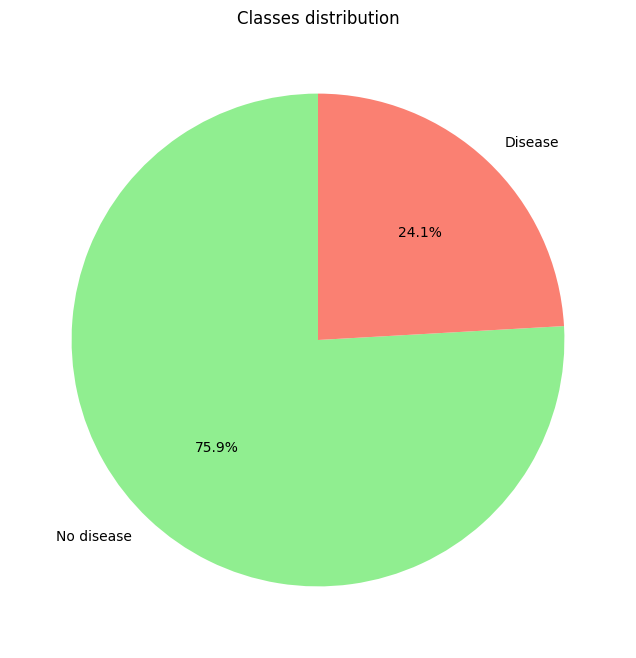

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = data.groupby(['disease_present']).size()
print(classes)
classes.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['No disease', 'Disease'],
    colors=['lightgreen', 'salmon'],
    figsize=(8, 8)
)

plt.title('Classes distribution')
plt.show()

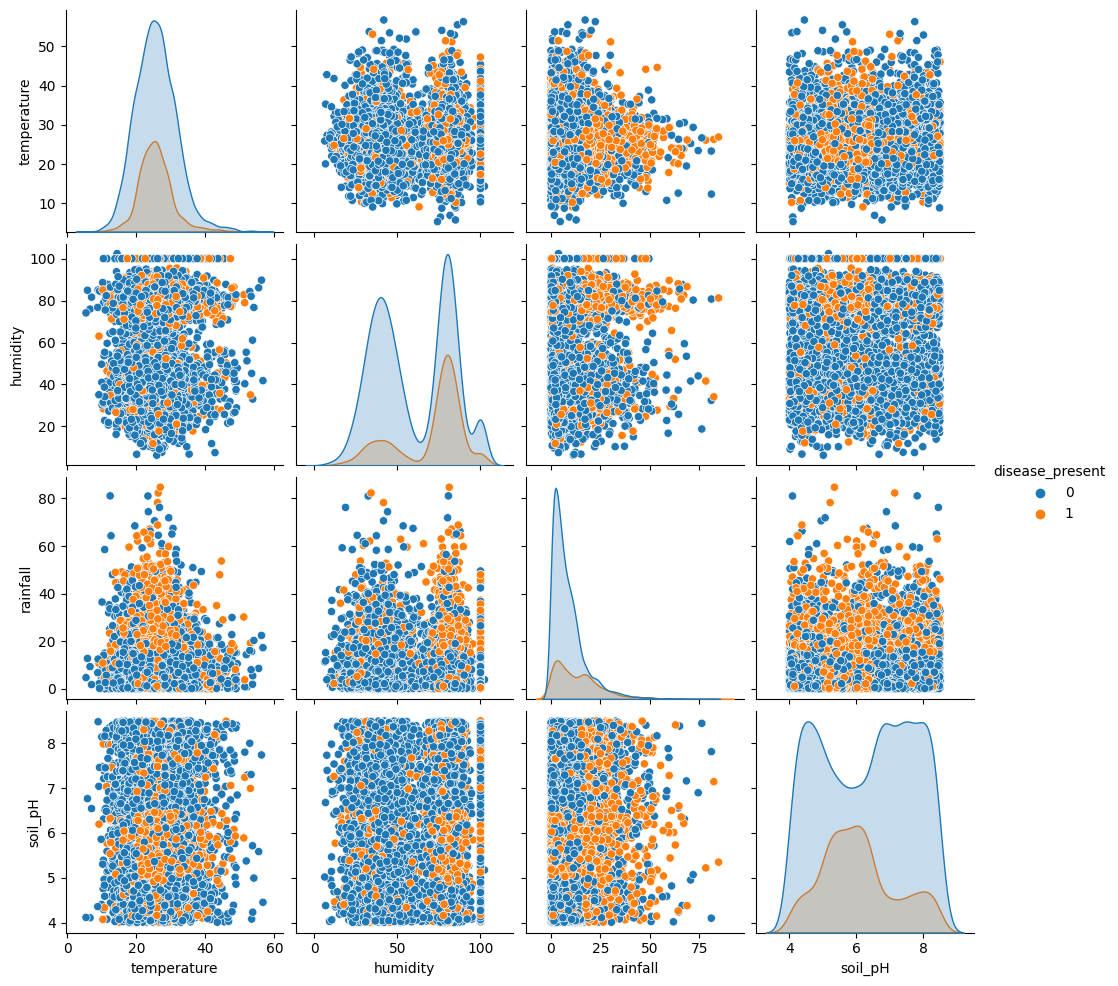

In [7]:
sns.pairplot(data, hue = 'disease_present')
plt.show()

In [8]:
data_grouped = data.groupby(['disease_present']).mean()
data_grouped

,temperature,humidity,rainfall,soil_pH
disease_present,,,,
0,25.615038,59.573134,8.593994,6.300228
1,25.603225,70.138138,13.629382,6.074615


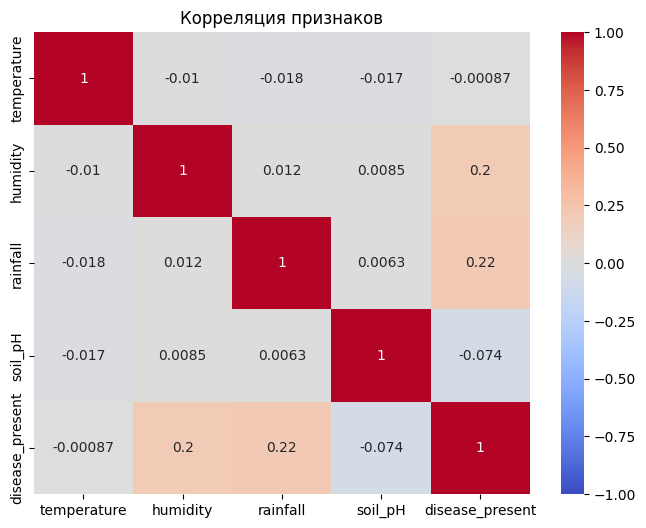

In [9]:
corr_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция признаков')
plt.show()


In [11]:
from sklearn.utils import resample

majority = data[data['disease_present'] == 0]
minority = data[data['disease_present'] == 1]

majority_downsampled = resample(
    majority,
    n_samples = int(len(minority) * 1.5),
    replace = False,
    random_state = 42
)


data_downsampled = pd.concat([majority_downsampled, minority])
data_downsampled = data_downsampled.sample(frac=1, random_state=42).reset_index(drop = True)
data_downsampled

,temperature,humidity,rainfall,soil_pH,disease_present
0,22.768397,70.204092,6.865029,5.044879,1
1,25.872889,38.925551,0.937621,5.225653,0
2,14.396499,18.668808,3.124504,8.464672,0
3,20.258260,36.669602,9.331673,7.743595,0
4,13.721043,86.786707,12.459177,6.038379,0
...,...,...,...,...,...
6020,28.193651,46.573211,4.804500,5.854960,1
6021,20.767511,85.515870,50.755172,5.727859,1
6022,29.971758,85.613856,3.623619,5.243874,1
6023,29.395071,78.144040,14.735889,7.437471,1


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class featuresCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 temp_hum = False, 
                 pH_hum = False, 
                 env_index = False,
                 rain_temp = False):
        
        self.temp_hum = temp_hum
        self.pH_hum = pH_hum
        self.env_index = env_index
        self.rain_temp = rain_temp

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        if self.temp_hum:
            X_copy['temp_hum'] = X_copy['temperature'] / X_copy['humidity']

        if self.pH_hum:
            X_copy['pH_hum'] = X_copy['soil_pH'] / X_copy['humidity']

        if self.env_index:
            X_copy['env_index'] = X_copy['temperature'] * X_copy['rainfall'] / X_copy['temperature'] 
            
        if self.rain_temp:
            X_copy['rain_temp'] = X_copy['rainfall'] / X_copy['temperature']
        

        return X_copy


# fcl = featuresCalculator(temp_hum = True, rainfall_hum = True, pH_hum = True)

# transformed = fcl.fit_transform(data)

# print(data)
# print(transformed)

In [14]:
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X = data_downsampled.drop(columns = ['disease_present'])
y = data_downsampled['disease_present'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

def objective(trial):
    scaler = StandardScaler()

    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    pipe = Pipeline(
        steps = [
            ('features', featuresCalculator(temp_hum = True, 
                                            pH_hum = True,
                                            env_index = True,
                                            rain_temp = True)),
            ('scaler', scaler),
            ('model', RandomForestClassifier(
                n_estimators = n_estimators,
                max_depth = max_depth,
                min_samples_split = min_samples_split,
                min_samples_leaf = min_samples_leaf,
                class_weight = 'balanced'
            ))
        ]
    )
    score = cross_val_score(pipe, X_train, y_train, cv = 5, scoring = 'accuracy')
    return score.mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

print('Best params:', study.best_params)
print('Best value:', study.best_value)

[I 2025-07-19 15:19:40,796] A new study created in memory with name: no-name-987d9eb1-855e-4048-8f69-f05b65ad72e2
[I 2025-07-19 15:20:04,078] Trial 0 finished with value: 0.8024896265560166 and parameters: {'n_estimators': 603, 'max_depth': 81, 'min_samples_split': 4, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.8024896265560166.
[I 2025-07-19 15:20:17,686] Trial 1 finished with value: 0.7970954356846474 and parameters: {'n_estimators': 376, 'max_depth': 46, 'min_samples_split': 12, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.8024896265560166.
[I 2025-07-19 15:20:22,352] Trial 2 finished with value: 0.8008298755186722 and parameters: {'n_estimators': 123, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.8024896265560166.
[I 2025-07-19 15:20:49,845] Trial 3 finished with value: 0.8016597510373444 and parameters: {'n_estimators': 730, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 11}. Best is trial 0 with 

Best params: {'n_estimators': 267, 'max_depth': 38, 'min_samples_split': 9, 'min_samples_leaf': 3}
Best value: 0.8072614107883818


In [15]:
best_params = study.best_params
print(best_params)

best_model = Pipeline([
    ('feature_eng', featuresCalculator(temp_hum = True, 
                                            pH_hum = True,
                                            env_index = True,
                                            rain_temp = True,)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(
        n_estimators = best_params['n_estimators'],
        max_depth = best_params['max_depth'],
        min_samples_split = best_params['min_samples_split'],
        min_samples_leaf = best_params['min_samples_leaf'],
        class_weight = 'balanced'
    ))
])

best_model.fit(X_train, y_train)

{'n_estimators': 267, 'max_depth': 38, 'min_samples_split': 9, 'min_samples_leaf': 3}


Pipeline(steps=[('feature_eng',
                 featuresCalculator(env_index=True, pH_hum=True, rain_temp=True,
                                    temp_hum=True)),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=38,
                                        min_samples_leaf=3, min_samples_split=9,
                                        n_estimators=267))])

In [16]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)

clr = classification_report(y_test, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       723
           1       0.87      0.66      0.75       482

    accuracy                           0.82      1205
   macro avg       0.84      0.80      0.81      1205
weighted avg       0.83      0.82      0.82      1205



In [17]:
best_model.named_steps['model'].feature_importances_

array([0.1192126 , 0.11871142, 0.10885974, 0.19452568, 0.11393672,
       0.15096148, 0.111465  , 0.08232738])

In [18]:
feature_names = X_train.columns.tolist()


feature_names += ['temp_hum', 'pH_hum', 'env_index', 'rain_temp']


import pandas as pd

importances = best_model.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)


       feature  importance
3      soil_pH    0.194526
5       pH_hum    0.150961
0  temperature    0.119213
1     humidity    0.118711
4     temp_hum    0.113937
6    env_index    0.111465
2     rainfall    0.108860
7    rain_temp    0.082327


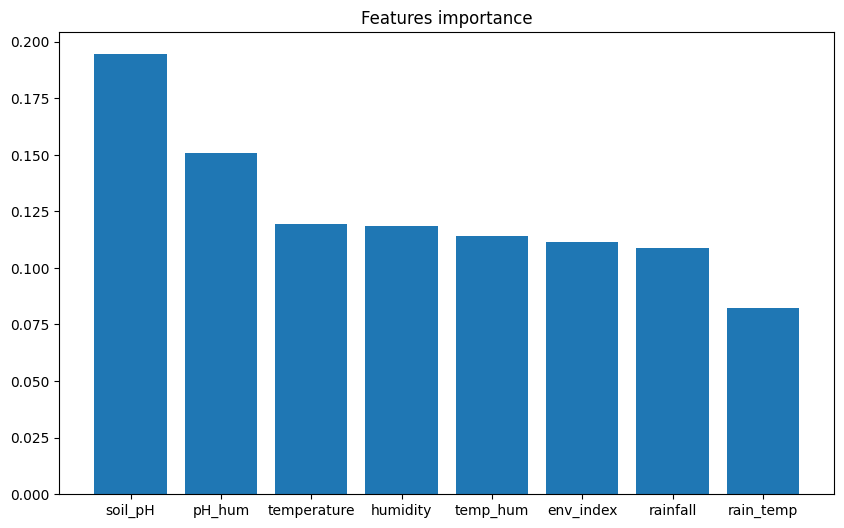

In [19]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Features importance')
plt.show()

# Climat changing risk analisys

In [20]:
changed_data = data.copy()
changed_data['temperature'] += 5
changed_data['humidity'] *= 1.1
changed_data['rainfall'] *= 1.2
changed_data

,temperature,humidity,rainfall,soil_pH,disease_present
0,32.483571,36.536558,0.687309,4.975875,1
1,29.308678,40.639506,51.026816,8.165266,0
2,33.238443,37.428808,19.314364,6.316734,1
3,37.615149,45.214599,24.373219,6.164949,0
4,28.829233,57.168964,14.221588,8.482468,0
...,...,...,...,...,...
9995,36.505510,90.133050,26.888187,5.862952,1
9996,20.008275,95.575516,12.604658,4.070539,0
9997,26.473416,90.080947,16.112243,7.101583,0
9998,32.478828,97.424414,11.663590,7.732620,0


In [21]:
y_pred_origin = best_model.predict_proba(data.drop(columns = ['disease_present']))
y_pred_changed = best_model.predict_proba(changed_data.drop(columns = ['disease_present']))

In [22]:
y_pred_origin

array([[0.36565217, 0.63434783],
       [0.65233185, 0.34766815],
       [0.10450582, 0.89549418],
       ...,
       [0.74679452, 0.25320548],
       [0.88730048, 0.11269952],
       [0.76974003, 0.23025997]])

In [23]:
y_pred_origin = y_pred_origin[:, 1]
y_pred_changed = y_pred_changed[:, 1]

risk_df = pd.DataFrame({
    'Original Risk': y_pred_origin,
    'Future Risk': y_pred_changed
})
risk_df

,Original Risk,Future Risk
0,0.634348,0.212498
1,0.347668,0.249298
2,0.895494,0.681051
3,0.567429,0.601225
4,0.180376,0.227693
...,...,...
9995,0.786037,0.691141
9996,0.198623,0.315745
9997,0.253205,0.800128
9998,0.112700,0.164097


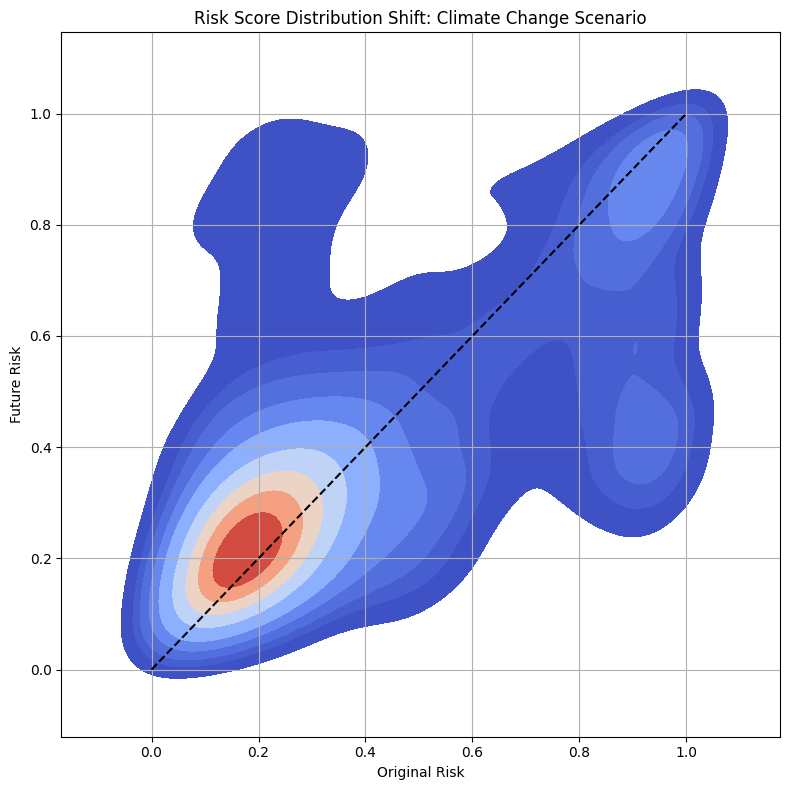

In [24]:
plt.figure(figsize=(8, 8))
sns.kdeplot(
    x= risk_df['Original Risk'],
    y= risk_df['Future Risk'],
    fill=True, cmap="coolwarm", thresh=0.05)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='No Risk Change Line')
plt.title("Risk Score Distribution Shift: Climate Change Scenario")
plt.xlabel("Original Risk")
plt.ylabel("Future Risk")
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion:
<span style="font-size:20px">The main concentration of data on the graph is located in the lower-left region and is highlighted in red, where the original risk is low (0.1–0.21), and the future risk lies in a slightly higher range (0.18–0.24). This upward shift in density relative to the diagonal line y = x indicates an overall increase in risk for the majority of cases.</span>

<span style="font-size:20px">Although the graph shows some instances where the risk decreases, their density is significantly lower, suggesting that such scenarios are relatively rare.</span>

<span style="font-size:20px">We can conclude that under the climate change scenario of +5°C, +10% humidity, and +20% rainfall, the risk of disease occurrence tends to increase in most cases.</span>